## Preparing the dataframe

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import joblib

print('modules loaded.')

modules loaded.


In [2]:
#Global parameters:
indir = '../input_files/trees_modified/'
#chno = 0 #mumu 

In [3]:
#Given a TFile, read its branches into a dataframe.
def read_file_into_df(filepath, truth):

    filename = filepath.split('/')[-1]
    sample = filename.split("_")[1]
    subsample = "_".join(filename.split("_")[2:])
    
    #Exceptions
    if 'QCD' in filename or 'VLL' in filename:
        sample = filename.split("_")[1]+"_"+filename.split("_")[2]
        subsample = filename.split("_")[3].split(".")[0]
        
    if subsample.endswith(".root"): subsample = subsample[:-5]

    tfile = uproot.open(filepath)
    ttree = tfile['myEvents']
    branches = ttree.keys()
    awkarray = ttree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    df['sample'] = sample
    df['subsample'] = subsample

    #print(f'dataframe for {sample} {subsample} loaded.')
    return df

def prepare_df(jobname, samples, truth, nmax=None):
    print(f'\nPicking files from {os.path.join(indir, jobname)}')
    dfout = pd.DataFrame()
    for s in samples:
        files = os.listdir(os.path.join(indir, jobname))
        for f in files:
            if s not in f: continue
            filepath = os.path.join(indir, jobname, f)
            df = read_file_into_df(filepath, truth)
            if df.empty:
                print(f"\033[0;31mWarning: Skipping empty file: {f}\033[0m")
                continue
            else:
                #Skim df:
                if nmax is not None and len(df) > nmax:
                    df = df.sample(frac=1).reset_index(drop=True)
                    df = df.head(nmax)
                    
                dfout = pd.concat([dfout, df], ignore_index=True)
                print(f"dataframe for {f} loaded.")

    return dfout

def plot_correlation_matrix(data, title, filename, alias_map=None):
    correlation_matrix = data.corr()
    nvar = len(data.columns)
    fig_size = (max(8, 0.4 * nvar), max(6, 0.4 * nvar))
    fig, ax = plt.subplots(figsize=fig_size)
    
    xticklabels = yticklabels = data.columns
    if alias_map:
        xticklabels = [alias_map.get(var, var) for var in data.columns]
        yticklabels = xticklabels
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
                cbar_kws={"shrink": .8}, ax=ax, xticklabels=xticklabels, yticklabels=yticklabels)
    
    ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_reduced_variables(df, prefix, modelname, ncols=3, vert=2.5, size=8):
    vars_to_plot = [col for col in df.columns if col.startswith(prefix)]
    
    if not vars_to_plot:
        print(f"No columns found with prefix '{prefix}'")
        return
    
    num_vars = len(vars_to_plot)
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * vert
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(size, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'bins': 'auto',
        'histtype': 'step',
        'linewidth': 1.5,
        'density': True,
        'log': False
    }
    
    for i, var in enumerate(vars_to_plot):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        
        ax[i].hist(sigdata, label=f'Sig [{nsig}]',     color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, label=f'Bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        
        ax[i].set_title(var, fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    # Remove extra subplots if any
    for j in range(i + 1, len(ax)): fig.delaxes(ax[j])

    plt.tight_layout()
    plt.savefig(f'{modelname}/{prefix}_histograms.png', dpi=300)
    plt.show()

print('Functions loaded.')

Functions loaded.


### Reading the trees into dataframes

In [4]:
%%time

bkgsamples = ['TTBar_TTTo2L2Nu', 'TTBar_TTToSemiLeptonic']
sigsamples = ['VLLD_mu_M200', 'VLLD_mu_M300', 'VLLD_mu_M400', 'VLLD_mu_M600', 'VLLD_mu_M800',
              'VLLD_ele_M200', 'VLLD_ele_M300', 'VLLD_ele_M400', 'VLLD_ele_M600', 'VLLD_ele_M800']

#bkgdf = prepare_df('tree_2018UL_searchregion', bkgsamples, 0)
bkgdf = pd.concat([
    prepare_df('tree_2018UL_searchregion', bkgsamples, 0),
    prepare_df('tree_2017UL_searchregion', bkgsamples, 0),
    prepare_df('tree_2016preVFPUL_searchregion', bkgsamples, 0),
    prepare_df('tree_2016postVFPUL_searchregion', bkgsamples, 0)
])
#sigdf = prepare_df('tree_2018UL_searchregion', sigsamples, 1)
sigdf = pd.concat([
    prepare_df('tree_2018UL_searchregion', sigsamples, 1),
    prepare_df('tree_2017UL_searchregion', sigsamples, 1),
    prepare_df('tree_2016preVFPUL_searchregion', sigsamples, 1),
    prepare_df('tree_2016postVFPUL_searchregion', sigsamples, 1)
])

print('\033[1;32mDone reading samples.\033[0m\n')


Picking files from ../input_files/trees_modified/tree_2018UL_searchregion
dataframe for tree_TTBar_TTTo2L2Nu.root loaded.
dataframe for tree_TTBar_TTToSemiLeptonic.root loaded.

Picking files from ../input_files/trees_modified/tree_2017UL_searchregion
dataframe for tree_TTBar_TTTo2L2Nu.root loaded.
dataframe for tree_TTBar_TTToSemiLeptonic.root loaded.

Picking files from ../input_files/trees_modified/tree_2016preVFPUL_searchregion
dataframe for tree_TTBar_TTTo2L2Nu.root loaded.
dataframe for tree_TTBar_TTToSemiLeptonic.root loaded.

Picking files from ../input_files/trees_modified/tree_2016postVFPUL_searchregion
dataframe for tree_TTBar_TTTo2L2Nu.root loaded.
dataframe for tree_TTBar_TTToSemiLeptonic.root loaded.

Picking files from ../input_files/trees_modified/tree_2018UL_searchregion
dataframe for tree_VLLD_mu_M200.root loaded.
dataframe for tree_VLLD_mu_M300.root loaded.
dataframe for tree_VLLD_mu_M400.root loaded.
dataframe for tree_VLLD_mu_M600.root loaded.
dataframe for tree_V

In [5]:
nsig_og = sigdf.shape[0]
nbkg_og = bkgdf.shape[0]
print(f'Signal: {nsig_og}')
print(f'Background: {nbkg_og}')

#Filtering:
filter = 'lep0_iso < 1.0 and lep1_iso < 1.0'
#filter = filter + ' and 0.50 < nnscore_qcd_vlldmu_200_800 < 0.70 and ST > 150'
sigdf = sigdf.query(filter)
bkgdf = bkgdf.query(filter)
bkgdf_reduced = bkgdf.sample(n=30000, random_state=42).reset_index(drop=True)

#Concatenating and filtering:
df = pd.concat([sigdf, bkgdf_reduced])
#df = pd.concat([sigdf, bkgdf])
df = df.sample(frac=1).reset_index(drop=True)
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]

print(f'Final signal and background: {nsig}, {nbkg}')

Signal: 27550
Background: 570437
Final signal and background: 27550, 30000


In [6]:
df.columns

Index(['channel', 'trigger', 'nlep', 'njet', 'nbjet', 'lep0_pt', 'lep0_eta',
       'lep0_phi', 'lep0_iso', 'lep0_sip3d', 'lep0_mt', 'lep1_pt', 'lep1_eta',
       'lep1_phi', 'lep1_iso', 'lep1_sip3d', 'lep1_mt', 'dilep_pt',
       'dilep_eta', 'dilep_phi', 'dilep_mass', 'dilep_mt', 'dilep_deta',
       'dilep_dphi', 'dilep_dR', 'dilep_ptratio', 'HT', 'LT', 'STvis', 'ST',
       'HTMETllpt', 'STfrac', 'metpt', 'metphi', 'dphi_metlep0',
       'dphi_metlep1', 'dphi_metdilep', 'dphi_metlep_max', 'dphi_metlep_min',
       'jec', 'jer', 'wt_leptonSF', 'wt_trig', 'wt_pileup', 'wt_bjet',
       'weight', 'nnscore_qcd_vlldele_2016postVFP',
       'nnscore_qcd_vlldele_2016preVFP', 'nnscore_qcd_vlldele_2017',
       'nnscore_qcd_vlldele_2018', 'nnscore_qcd_vlldmu_2016postVFP',
       'nnscore_qcd_vlldmu_2016preVFP', 'nnscore_qcd_vlldmu_2017',
       'nnscore_qcd_vlldmu_2018', 'nnscore_qcd_vlld_2016postVFP',
       'nnscore_qcd_vlld_2016preVFP', 'nnscore_qcd_vlld_2017',
       'nnscore_qcd_vlld_2

In [7]:
df

,channel,trigger,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,...,nnscore_qcd_vlld_2016postVFP,nnscore_qcd_vlld_2016preVFP,nnscore_qcd_vlld_2017,nnscore_qcd_vlld_2018,flag_searchregion,flag_val,flag_qcd,truth,sample,subsample
0,0,0,2,2,0,27.949224,0.866455,-0.059616,0.030494,0.359863,...,0.435184,0.764214,0.356711,0.483071,True,False,False,1,VLLD_mu,M200
1,2,1,2,2,1,58.788284,1.518066,-1.672363,0.044565,0.636719,...,0.923993,0.925928,0.920766,0.917355,True,False,False,0,TTBar,TTToSemiLeptonic
2,3,1,2,4,1,80.364273,0.885376,-2.614746,0.003019,1.718750,...,0.956309,0.986090,0.940885,0.822524,True,False,False,0,TTBar,TTToSemiLeptonic
3,1,2,2,1,1,250.221176,1.755127,2.848145,0.000738,0.484619,...,0.990034,0.992662,0.956909,0.970202,True,False,False,1,VLLD_mu,M600
4,0,0,2,4,1,244.645142,1.482666,0.600830,0.048589,0.355713,...,0.975456,0.976625,0.944751,0.973741,True,False,False,0,TTBar,TTToSemiLeptonic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57545,3,3,2,2,1,45.013954,-0.255493,2.473145,0.000000,1.407227,...,0.901334,0.884401,0.892318,0.898618,True,False,False,0,TTBar,TTTo2L2Nu
57546,1,1,2,1,0,183.801544,0.660156,0.942139,0.005290,0.225098,...,0.888131,0.932671,0.846090,0.863514,True,False,False,1,VLLD_mu,M300
57547,0,0,2,2,1,95.130547,0.941528,2.263672,0.129627,0.318359,...,0.968999,0.943958,0.945987,0.962527,True,False,False,0,TTBar,TTToSemiLeptonic
57548,0,0,2,2,1,88.769287,2.000977,-2.051758,0.000000,0.960938,...,0.830570,0.652266,0.826711,0.809986,True,False,False,0,TTBar,TTToSemiLeptonic


### Exploring the variables

In [8]:
import matplotlib.pyplot as plt
import math
#os.makedirs(f'{modelname}/before_training', exist_ok=True)

def latexname(var, alias): return alias.get(var, var) #Either get the latexname, or return the default name.

def plot_in_group(listvar, figname, suptitle=None, alias=None, ncols=4, vert=2.5, size=12):
    num_vars = len(listvar)
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * vert
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(size, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'bins':'auto',
        'histtype':'step',
        'linewidth':1.5,
        'density':True,
        'log':False
    }
    
    for i, var in enumerate(listvar):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        ax[i].hist(sigdata, label=f'sig [{nsig}]', color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, label=f'bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        if not alias: ax[i].set_title(var, fontsize=10)
        else: ax[i].set_title(latexname(var, alias), fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    for j in range(i+1, len(ax)): fig.delaxes(ax[j])

    if suptitle: fig.suptitle(suptitle, fontsize=12)    
    
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()

print('Ready to plot!')

Ready to plot!


The following input variables are chosen.
dilep_pt            dilep_pt
dilep_mt            $M_{T}^{\text{  LL}}$
dilep_dphi          $\Delta\phi(L_{0}, L_{1})$
dilep_ptratio       $p_{T1}/p_{T0}$
LT                  $L_{T}$
ST                  ST
STfrac              $S_{T}^{\text{  frac}}$
dphi_metlep0        $\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$
dphi_metlep1        $\Delta\phi(L_{1}, p_{T}^{\text{  miss}})$
dphi_metlep_min     $min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$


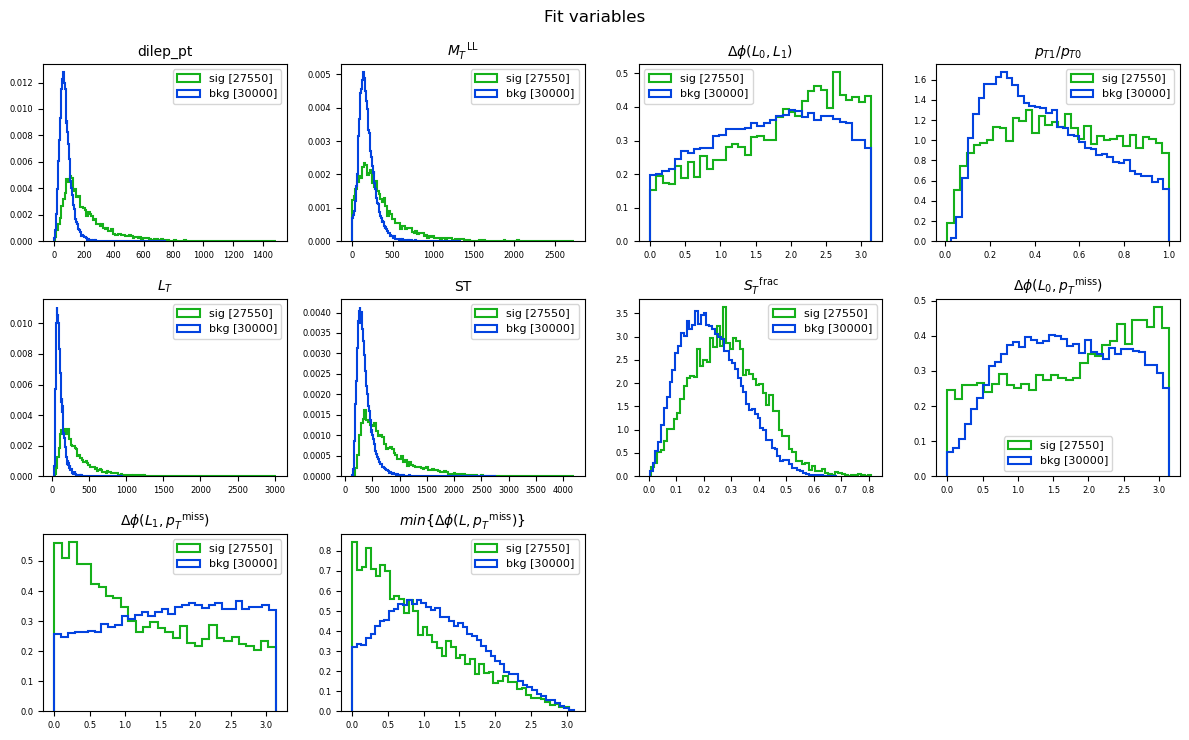

In [9]:
fit_var = [
    'dilep_pt',
    'dilep_mt',
    'dilep_dphi',
    'dilep_ptratio',
    'LT',
    'ST',
    'STfrac',
    'dphi_metlep0',
    'dphi_metlep1',
    'dphi_metlep_min',
]

alias_ = {
    'njet':            r'$N_{\text{J}}$',
    'lep0_eta':        r'$\eta (L_0)$',
    'lep1_eta':        r'$\eta (L_1)$',
    'dilep_mt':        r'$M_{T}^{\text{  LL}}$',
    'dilep_dR':        r'$\Delta R(L_{0}, L_{1})$',
    'dilep_dphi':      r'$\Delta\phi(L_{0}, L_{1})$',
    'dilep_deta':      r'$\Delta\eta(L_{0}, L_{1})$',
    'dilep_ptratio':   r'$p_{T1}/p_{T0}$',
    'HTMETllpt':       r'$H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$',
    'HT':              r'$H_{T}$',
    'LT':              r'$L_{T}$',
    'STfrac':          r'$S_{T}^{\text{  frac}}$',
    'dphi_metlep0':    r'$\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$',
    'dphi_metlep1':    r'$\Delta\phi(L_{1}, p_{T}^{\text{  miss}})$',
    'dphi_metdilep':   r'$\Delta\phi(LL, p_{T}^{\text{  miss}})$',
    'dphi_metlep_max': r'$max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'dphi_metlep_min': r'$min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'metpt':           r'$p_{T}^{\text{  miss}}$',
    'metphi':          r'$\phi^{\text{  miss}}$',
} #Uses these names in plot. If not mentioned here, uses the dafault name.

print('The following input variables are chosen.')
for var in fit_var: print(f"{var:<20}{latexname(var, alias_)}")

plot_in_group(fit_var, 'fit_varriables', suptitle='Fit variables', alias=alias_)

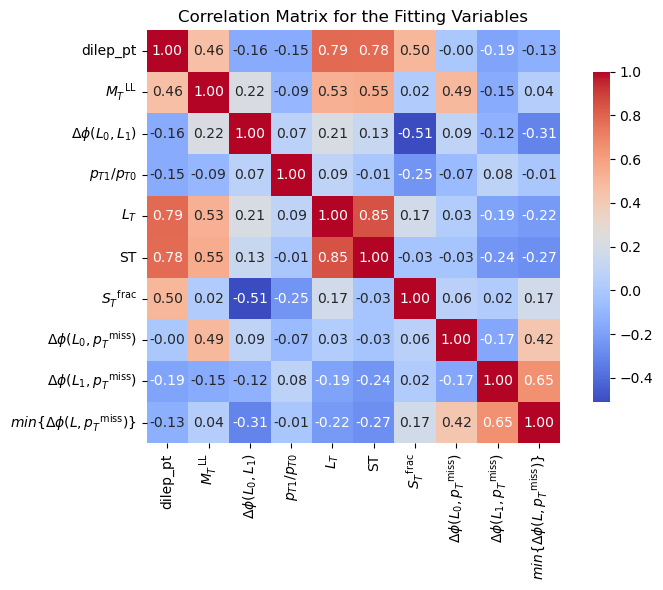

In [10]:
plot_correlation_matrix(df[fit_var], 
                        'Correlation Matrix for the Fitting Variables', 
                        f'correlation_fitvar.png', 
                        alias_map={var: latexname(var, alias_) for var in fit_var})

# PCA

In [11]:
modelname = 'PCA-ttbar-vlld-feb13'
os.makedirs(modelname, exist_ok=True)

### Fitting

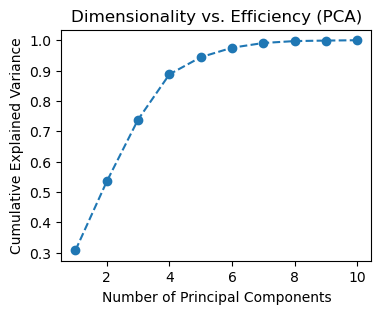

In [12]:
X = df[fit_var]

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--", label="Cumulative Explained Variance")
ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Cumulative Explained Variance")
ax.set_title("Dimensionality vs. Efficiency (PCA)")
plt.savefig(f"{modelname}/dim_vs_eff.png", dpi=300)
plt.show()

### Choosing a reduced dimension

In [13]:
# Manually choose the number of components based on the plot
n_components = 4

# Apply PCA with chosen components
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

# Save PCA model and scaler
joblib.dump(pca,    f"{modelname}/pca_model.pkl")
joblib.dump(scaler, f"{modelname}/scaler.pkl")

# Create a new DataFrame with PCA components
df_pca = pd.DataFrame(X_reduced, columns=[f"PCA_{i}" for i in range(n_components)])
df_pca["truth"] = df["truth"].values 

# If needed, reset index to align with original df for future merging
df_pca.index = df.index  # Ensures the same index as the original df

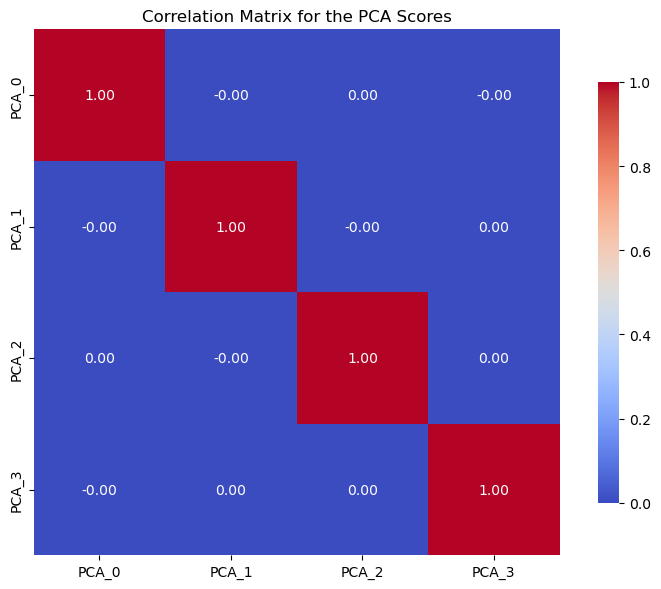

In [14]:
plot_correlation_matrix(df_pca.filter(like='PCA'), 
                        'Correlation Matrix for the PCA Scores', 
                        f'{modelname}/correlation_PCA.png', 
                        alias_map={var: latexname(var, alias_) for var in fit_var})

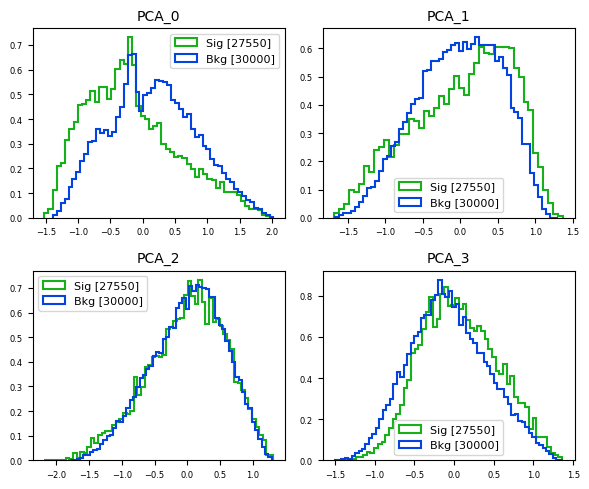

In [15]:
plot_reduced_variables(df_pca, "PCA", modelname, ncols=2, vert=2.5, size=6)

# LDA

In [16]:
modelname = 'LDA-ttbar-vlld-feb13'
os.makedirs(modelname, exist_ok=True)

### Fitting

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Load features (X) and labels (y)
X = df[fit_var]
y = df["truth"]  # LDA requires class labels

# Standardize the features
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Apply LDA
lda = LDA()
X_lda = lda.fit_transform(X_scaled, y)

# Save LDA model and scaler
joblib.dump(lda, f"{modelname}/lda_model.pkl")
joblib.dump(scaler, f"{modelname}/scaler.pkl")

# Add the LDA component to a new DataFrame
df_lda = pd.DataFrame(X_lda, columns=[f"LDA_{i}" for i in range(X_lda.shape[1])])
df_lda["truth"] = df["truth"].values  # Keep class labels

# Ensure the index matches df for merging if needed
df_lda.index = df.index

# Print LDA explained variance (not very useful for 1 component)
if X_lda.shape[1] > 1:
    explained_variance = np.cumsum(lda.explained_variance_ratio_)
    
    # Plot Dimensionality vs. Efficiency (if applicable)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--", label="Cumulative Explained Variance")
    ax.set_xlabel("Number of LDA Components")
    ax.set_ylabel("Cumulative Explained Variance")
    ax.set_title("Dimensionality vs. Efficiency (LDA)")
    plt.savefig(f"{modelname}/dim_vs_eff.png", dpi=300)
    plt.show()
else:
    print("LDA has only one component (expected for binary classification).")


LDA has only one component (expected for binary classification).


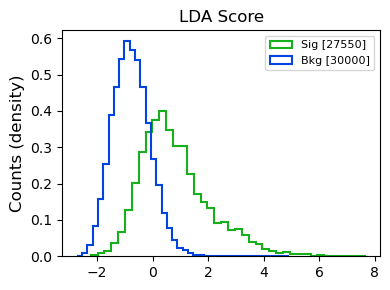

In [18]:
decorate_hist = {
    'bins': 40,
    'histtype': 'step',
    'linewidth': 1.5,
    'density': True,
    'log': False
}

# Extract LDA scores for signal and background
sigdata = df_lda[df_lda["truth"] == 1]["LDA_0"]
bkgdata = df_lda[df_lda["truth"] == 0]["LDA_0"]
nsig = len(sigdata)
nbkg = len(bkgdata)

# Plot histograms
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(sigdata, label=f"Sig [{nsig}]", color="xkcd:green", **decorate_hist)
ax.hist(bkgdata, label=f"Bkg [{nbkg}]", color="xkcd:blue", **decorate_hist)

# Formatting
ax.set_ylabel("Counts (density)", fontsize=12)  # Y-axis now correctly shows counts
ax.set_title("LDA Score", fontsize=12)
ax.legend(loc="best", fontsize=8)
ax.tick_params(axis="both", labelsize=10)

# Save figure
plt.tight_layout()
plt.savefig(f"{modelname}/lda_score.png", dpi=300)
plt.show()